## Weighted Pool PCF

### Setup and Configuration

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import seaborn as sns
import pickle
from tqdm import tqdm

sns.set(color_codes=True, style="white")

# === ANALYSIS CONFIGURATION ===
folder_save = "/Volumes/guttman/Guoming_Gao-Resnick/Data_BIF/DEFAULT_USER/20250424_ONIdemo_Guoming/Guoming_data/dSTORM/dSTORM_tif/Xist"
os.chdir(folder_save)

# Condition settings
label = "Xist Exon"
color = "#660000"

# Find all pickle files for this condition
pkl_files = [f for f in os.listdir(".") if f.endswith("perCell_crossPCF.p")]
print(f"Found {len(pkl_files)} pickle files to combine:")
for f in pkl_files:
    print(f"  • {f}")

Found 2 pickle files to combine:
  • dSTORM2_TX_diff_XistEx_AF647_AF488-2-perCell_crossPCF.p
  • dSTORM2_TX_diff_XistEx_AF647_AF488-4-perCell_crossPCF.p


### Data Loading and Combination Functions

In [2]:
def load_and_combine_pcf_data(pkl_files, quality_threshold=0.2):
    """
    Load multiple pickle files and combine them into analysis format.

    Args:
        pkl_files: List of pickle filenames to combine
        quality_threshold: Maximum baseline_cv to include (default 20%)

    Returns:
        dict: Combined data in analysis format
    """
    print(f"\nLoading and combining {len(pkl_files)} files...")

    combined_pcf_list = []
    combined_weights = []
    spatial_params = None

    total_cells_found = 0
    total_cells_included = 0

    for pkl_file in tqdm(pkl_files, desc="Loading files"):
        try:
            with open(pkl_file, "rb") as f:
                data = pickle.load(f)

            # Store spatial parameters from first file
            if spatial_params is None:
                spatial_params = {
                    "nm_per_pxl": data["nm_per_pxl"],
                    "r_max_nm": data["r_max_nm"],
                    "ringwidth_nm": data["ringwidth_nm"],
                    "dr_slidingrings_nm": data["dr_slidingrings_nm"],
                    "bin_centers": data["bin_centers"],
                }

            # Process each cell in this file
            for cell_result in data["normalized_results"]:
                total_cells_found += 1

                # Quality filter
                baseline_cv = cell_result.get("baseline_cv", 1.0)
                if baseline_cv <= quality_threshold:
                    # Extract PCF data
                    pcf_data = cell_result["pcf_normalized"]

                    # Calculate combined weight (N_interest + N_ref)
                    weight = cell_result["N_interest"] + cell_result["N_ref"]

                    combined_pcf_list.append(pcf_data)
                    combined_weights.append(weight)
                    total_cells_included += 1

        except Exception as e:
            print(f"Warning: Error loading {pkl_file}: {e}")

    print(f"Combined data summary:")
    print(f"  • Total cells found: {total_cells_found}")
    print(f"  • High-quality cells included: {total_cells_included}")
    print(f"  • Quality threshold: baseline_cv ≤ {quality_threshold:.1%}")
    print(f"  • Weight calculation: N_interest + N_ref")

    return {
        "pcf_data": combined_pcf_list,
        "weights": combined_weights,
        "spatial_params": spatial_params,
        "summary": {
            "n_files": len(pkl_files),
            "n_cells_total": total_cells_found,
            "n_cells_included": total_cells_included,
            "quality_threshold": quality_threshold,
        },
    }


def prepare_analysis_data(combined_data):
    """
    Convert combined data to format expected by analysis functions.
    """
    return {
        "pcf_per_cell": combined_data["pcf_data"],
        "weights_per_cell": combined_data["weights"],
        "bins": combined_data["spatial_params"]["bin_centers"],
        "nm_per_pxl": combined_data["spatial_params"]["nm_per_pxl"],
        "r_max_nm": combined_data["spatial_params"]["r_max_nm"],
    }

### Statistical Analysis Functions

In [3]:
def calculate_weighted_statistics(pcf_per_cell, weights_per_cell):
    """
    Calculate weighted mean, SEM, and STD across cells.

    Args:
        pcf_per_cell: List of PCF arrays (one per cell)
        weights_per_cell: List of weights (one per cell)

    Returns:
        tuple: (weighted_mean, weighted_sem, weighted_std)
    """
    n_cells = len(weights_per_cell)
    n_bins = pcf_per_cell[0].shape[0]

    weighted_mean = np.zeros(n_bins)
    weighted_sem = np.zeros(n_bins)
    weighted_std = np.zeros(n_bins)
    weights = np.array(weights_per_cell)

    for i in range(n_bins):
        # Extract values for this distance bin across all cells
        values = np.array([pcf_per_cell[j][i] for j in range(n_cells)])

        # Remove NaN values
        valid_mask = ~(np.isnan(values) | np.isnan(weights))
        valid_values = values[valid_mask]
        valid_weights = weights[valid_mask]

        if len(valid_values) > 0:
            # Calculate weighted statistics
            weighted_mean[i] = np.average(valid_values, weights=valid_weights)
            variance = np.average((valid_values - weighted_mean[i])**2, weights=valid_weights)
            weighted_sem[i] = np.sqrt(variance / len(valid_values))
            weighted_std[i] = np.sqrt(variance)
        else:
            weighted_mean[i] = np.nan
            weighted_sem[i] = np.nan
            weighted_std[i] = np.nan

    return weighted_mean, weighted_sem, weighted_std

def critical_system_PCF(distance, amplitude, decay_length):
    """
    Exponential decay model for PCF: g(r) = 1 + A * exp(-r/r0)

    Args:
        distance: Distance values (nm)
        amplitude: Amplitude parameter A
        decay_length: Characteristic decay length r0 (nm)

    Returns:
        numpy.array: Model values
    """
    return 1 + amplitude * np.exp(-distance / decay_length)

def fit_pcf_model(bins, weighted_mean, fit_bounds=([-1, 0], [5, 500])):
    """
    Fit exponential decay model to weighted PCF data.

    Args:
        bins: Distance bins (nm)
        weighted_mean: Weighted mean PCF values
        fit_bounds: Parameter bounds [(A_min, r0_min), (A_max, r0_max)]

    Returns:
        tuple: (amplitude, decay_length, fit_covariance)
    """
    # Skip first bin (distance = 0) for fitting
    popt, pcov = curve_fit(
        critical_system_PCF,
        bins[1:],
        weighted_mean[1:],
        bounds=fit_bounds
    )

    amplitude, decay_length = popt
    return amplitude, decay_length, pcov


def calculate_fit_metrics(bins, weighted_mean, amplitude, decay_length):
    """
    Calculate more appropriate fit quality metrics for PCF data.
    """
    # Generate model predictions
    model_values = critical_system_PCF(bins, amplitude, decay_length)

    # Remove any NaN values for calculations
    valid_mask = ~(np.isnan(weighted_mean) | np.isnan(model_values))
    obs = weighted_mean[valid_mask]
    pred = model_values[valid_mask]

    # 1. R-squared (coefficient of determination)
    ss_res = np.sum((obs - pred) ** 2)  # Sum of squares of residuals
    ss_tot = np.sum((obs - np.mean(obs)) ** 2)  # Total sum of squares
    r_squared = 1 - (ss_res / ss_tot)

    # 2. Root Mean Square Error (RMSE)
    rmse = np.sqrt(np.mean((obs - pred) ** 2))

    # 3. Mean Absolute Error (MAE)
    mae = np.mean(np.abs(obs - pred))

    # 4. Maximum residual
    max_residual = np.max(np.abs(obs - pred))

    # 5. Systematic deviation test (are residuals random?)
    residuals = obs - pred
    # Simple run test: count sign changes in residuals
    sign_changes = np.sum(np.diff(np.sign(residuals)) != 0)
    expected_sign_changes = len(residuals) - 1  # If random

    return {
        'r_squared': r_squared,
        'rmse': rmse,
        'mae': mae,
        'max_residual': max_residual,
        'sign_changes': sign_changes,
        'expected_sign_changes': expected_sign_changes,
        'residuals': residuals
    }

def assess_fit_quality(fit_metrics):
    """
    Provide qualitative assessment of fit quality.
    """
    r_sq = fit_metrics['r_squared']
    sign_ratio = fit_metrics['sign_changes'] / fit_metrics['expected_sign_changes']

    # R-squared interpretation
    if r_sq > 0.95:
        r_sq_quality = "Excellent"
    elif r_sq > 0.90:
        r_sq_quality = "Good"
    elif r_sq > 0.80:
        r_sq_quality = "Acceptable"
    else:
        r_sq_quality = "Poor"

    # Systematic deviation check
    if 0.3 < sign_ratio < 0.7:
        pattern_quality = "Random residuals (good)"
    else:
        pattern_quality = "Systematic deviations (concerning)"

    return {
        'overall_quality': r_sq_quality,
        'residual_pattern': pattern_quality,
        'r_squared_pct': r_sq * 100
    }

### Bootstrap Analysis Functions

In [4]:
def bootstrap_analysis(
    analysis_data,
    n_bootstrap_samples=30,
    n_bootstrap_rounds=1000,
    fit_bounds=([-1, 0], [5, 500]),
):
    """
    Perform bootstrap analysis to estimate parameter uncertainties.

    Args:
        analysis_data: Dictionary with pcf_per_cell, weights_per_cell, bins
        n_bootstrap_samples: Number of cells to sample per bootstrap round
        n_bootstrap_rounds: Number of bootstrap iterations
        fit_bounds: Parameter bounds for fitting

    Returns:
        dict: Bootstrap results with parameter distributions and confidence intervals
    """
    print(f"Running bootstrap analysis ({n_bootstrap_rounds} rounds)...")

    pcf_per_cell = analysis_data["pcf_per_cell"]
    weights_per_cell = analysis_data["weights_per_cell"]
    bins = analysis_data["bins"]

    n_cells_available = len(pcf_per_cell)
    n_samples = min(n_bootstrap_samples, n_cells_available)

    bootstrap_amplitudes = []
    bootstrap_decay_lengths = []
    bootstrap_r_squared_values = []  # ✅ Changed from bootstrap_chi_squares

    for round_idx in tqdm(range(n_bootstrap_rounds), desc="Bootstrap rounds"):
        # Randomly sample cells with replacement
        sample_indices = np.random.choice(n_cells_available, n_samples, replace=True)

        sampled_pcf = [pcf_per_cell[i] for i in sample_indices]
        sampled_weights = [weights_per_cell[i] for i in sample_indices]

        # Calculate statistics for this bootstrap sample
        boot_mean, _, boot_std = calculate_weighted_statistics(
            sampled_pcf, sampled_weights
        )

        try:
            # Fit model to bootstrap sample
            amplitude, decay_length, _ = fit_pcf_model(bins, boot_mean, fit_bounds)

            # ✅ Calculate R-squared instead of chi-squared
            fit_metrics = calculate_fit_metrics(
                bins, boot_mean, amplitude, decay_length
            )
            r_squared = fit_metrics["r_squared"]

            bootstrap_amplitudes.append(amplitude)
            bootstrap_decay_lengths.append(decay_length)
            bootstrap_r_squared_values.append(r_squared)  # ✅ Changed variable name

        except Exception as e:
            # Skip failed fits
            continue

    # Calculate confidence intervals (5th and 95th percentiles)
    def get_confidence_interval(values, confidence=90):
        lower = (100 - confidence) / 2
        upper = 100 - lower
        return np.percentile(values, [lower, upper])

    amplitude_ci = get_confidence_interval(bootstrap_amplitudes)
    decay_length_ci = get_confidence_interval(bootstrap_decay_lengths)
    r_squared_ci = get_confidence_interval(bootstrap_r_squared_values)  # ✅ Added R² CI

    results = {
        "amplitude_values": bootstrap_amplitudes,
        "decay_length_values": bootstrap_decay_lengths,
        "r_squared_values": bootstrap_r_squared_values,  # ✅ Changed from chi_square_values
        "amplitude_ci": amplitude_ci,
        "decay_length_ci": decay_length_ci,
        "r_squared_ci": r_squared_ci,  # ✅ Added R² confidence interval
        "amplitude_mean": np.mean(bootstrap_amplitudes),
        "amplitude_std": np.std(bootstrap_amplitudes),
        "decay_length_mean": np.mean(bootstrap_decay_lengths),
        "decay_length_std": np.std(bootstrap_decay_lengths),
        "r_squared_mean": np.mean(bootstrap_r_squared_values),  # ✅ Added R² statistics
        "r_squared_std": np.std(bootstrap_r_squared_values),
        "n_successful_fits": len(bootstrap_amplitudes),
    }

    print(f"Bootstrap completed:")
    print(f"  • Successful fits: {results['n_successful_fits']}/{n_bootstrap_rounds}")
    print(
        f"  • Amplitude: {results['amplitude_mean']:.3f} ± {results['amplitude_std']:.3f}"
    )
    print(
        f"  • Decay length: {results['decay_length_mean']:.1f} ± {results['decay_length_std']:.1f} nm"
    )
    print(
        f"  • R²: {results['r_squared_mean']:.3f} ± {results['r_squared_std']:.3f}"
    )  # ✅ Added R² summary

    return results

### Main Analysis Pipeline

#### Fitting

In [5]:
# Step 1: Load and combine data
combined_data = load_and_combine_pcf_data(pkl_files, quality_threshold=0.2)
analysis_data = prepare_analysis_data(combined_data)

# Step 2: Calculate weighted statistics
print(f"\nCalculating weighted statistics...")
weighted_mean, weighted_sem, weighted_std = calculate_weighted_statistics(
    analysis_data["pcf_per_cell"], analysis_data["weights_per_cell"]
)

# Step 3: Fit exponential decay model
print(f"Fitting exponential decay model...")
dr_ring = combined_data["spatial_params"]["ringwidth_nm"]
fit_bounds = ([-1, 0], [5, 500])  # [A_min, r0_min], [A_max, r0_max]
amplitude, decay_length, fit_covariance = fit_pcf_model(
    analysis_data["bins"] - dr_ring / 2, weighted_mean, fit_bounds
)

# Step 4: Assess fit quality
# Replace your chi-squared calculation with these metrics
print(f"Calculating improved fit quality metrics...")

fit_metrics = calculate_fit_metrics(
    analysis_data["bins"] - dr_ring / 2, weighted_mean, amplitude, decay_length
)

quality_assessment = assess_fit_quality(fit_metrics)

print(f"\nImproved Fit Quality Assessment:")
print(
    f"  • R² = {fit_metrics['r_squared']:.3f} ({quality_assessment['r_squared_pct']:.1f}% variance explained)"
)
print(f"  • RMSE = {fit_metrics['rmse']:.3f}")
print(f"  • Max residual = {fit_metrics['max_residual']:.3f}")
print(f"  • Overall quality: {quality_assessment['overall_quality']}")
print(f"  • Residual pattern: {quality_assessment['residual_pattern']}")


Loading and combining 2 files...


Loading files: 100%|██████████| 2/2 [00:00<00:00, 229.68it/s]

Combined data summary:
  • Total cells found: 10
  • High-quality cells included: 9
  • Quality threshold: baseline_cv ≤ 20.0%
  • Weight calculation: N_interest + N_ref

Calculating weighted statistics...
Fitting exponential decay model...
Calculating improved fit quality metrics...

Improved Fit Quality Assessment:
  • R² = 0.989 (98.9% variance explained)
  • RMSE = 0.036
  • Max residual = 0.075
  • Overall quality: Excellent
  • Residual pattern: Systematic deviations (concerning)


#### Bootstrap

Running bootstrap analysis (2000 rounds)...


Bootstrap rounds: 100%|██████████| 2000/2000 [00:02<00:00, 688.85it/s]


Bootstrap completed:
  • Successful fits: 2000/2000
  • Amplitude: 2.213 ± 0.992
  • Decay length: 163.3 ± 60.3 nm
  • R²: 0.970 ± 0.025


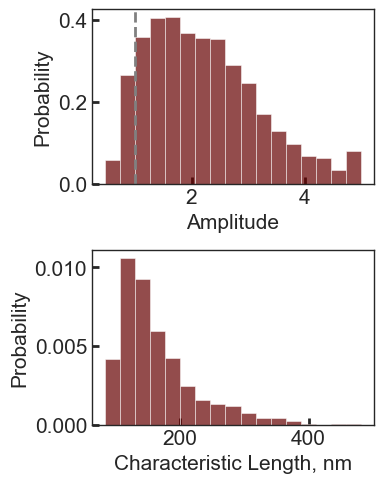

✅ Bootstrap distributions saved as: bootstrap_distributions_Xist_Exon.png


In [6]:
bootstrap_results = bootstrap_analysis(
    analysis_data,
    n_bootstrap_samples=20,
    n_bootstrap_rounds=2000,
    fit_bounds=([-1, 0], [5, 500]),
)
# Two-panel bootstrap distribution plot
fig, axes = plt.subplots(2, 1, figsize=(4, 5))

# === TOP PANEL: AMPLITUDE DISTRIBUTION ===
axes[0].hist(
    bootstrap_results["amplitude_values"],
    bins=17,
    alpha=0.7,
    color=color,
    density=True,
    edgecolor="white",
    linewidth=0.5,
)
axes[0].axvline(1, ls="--", c="gray", lw=2)

# Styling for top panel
axes[0].set_xlabel("Amplitude", fontsize=15)
axes[0].set_ylabel("Probability", fontsize=15)

# Apply custom spine and tick styling
axes[0].spines[:].set_linewidth(1)
axes[0].tick_params(
    axis="both",
    which="major",
    labelsize=15,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)

# === BOTTOM PANEL: CHARACTERISTIC LENGTH DISTRIBUTION ===
axes[1].hist(
    bootstrap_results["decay_length_values"],
    bins=17,
    alpha=0.7,
    color=color,
    density=True,
    edgecolor="white",
    linewidth=0.5,
)

# Styling for bottom panel
axes[1].set_xlabel("Characteristic Length, nm", fontsize=15)
axes[1].set_ylabel("Probability", fontsize=15)

# Apply custom spine and tick styling
axes[1].spines[:].set_linewidth(1)
axes[1].tick_params(
    axis="both",
    which="major",
    labelsize=15,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)

# Overall plot adjustments
plt.tight_layout()

# Save with descriptive filename
filename = f"bootstrap_distributions_{label.replace(' ', '_')}.png"
plt.savefig(filename, format="png", bbox_inches="tight", dpi=300)
plt.show()

print(f"✅ Bootstrap distributions saved as: {filename}")

#### Fitting plus bootstrap CI

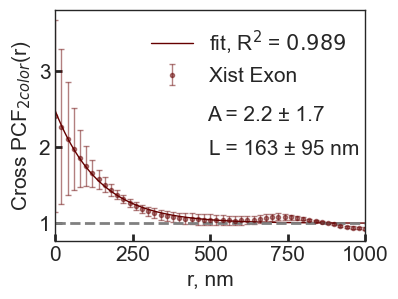

In [7]:
def preset_plot(bins, weighted_mean, weighted_sem, a, r0, c, label, R2):
    plt.errorbar(
        bins,
        weighted_mean,
        yerr=weighted_sem,
        fmt=".",
        color=c,
        ecolor=c,
        elinewidth=1,
        capsize=2,
        alpha=0.5,
        label=label,
    )
    r_fit = np.linspace(bins[0], bins[-1], 500)
    plt.plot(
        r_fit,
        critical_system_PCF(r_fit, a, r0),
        c=c,
        lw=1,
        label=f"fit, R$^2$ = ${R2:.3f}$",
    )


plt.figure(figsize=(4, 3))
bins = analysis_data["bins"] - dr_ring / 2
preset_plot(
    bins,
    weighted_mean,
    weighted_sem,
    amplitude,
    decay_length,
    color,
    label,
    fit_metrics["r_squared"],
)
plt.axhline(1, ls="--", c="gray", lw=2)

# Other plot settings
plt.legend(frameon=False, fontsize=15)
plt.xlim(bins[0], bins[-1])
# plt.ylim(0.8, 3)
plt.xlabel("r, nm", fontsize=15)
plt.ylabel("Cross PCF$_{2color}$(r)", fontsize=15)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=15,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)

# === ADD BOOTSTRAP STATISTICS TEXT ===
# Calculate bootstrap statistics for display
if "bootstrap_results" in locals():
    # Get mean and confidence intervals
    amp_mean = bootstrap_results["amplitude_mean"]
    amp_ci = bootstrap_results["amplitude_ci"]
    amp_error = (amp_ci[1] - amp_ci[0]) / 2  # Half-width of CI as error

    length_mean = bootstrap_results["decay_length_mean"]
    length_ci = bootstrap_results["decay_length_ci"]
    length_error = (length_ci[1] - length_ci[0]) / 2  # Half-width of CI as error

    # Add text annotations - MANUAL POSITIONING COORDINATES
    # You can adjust these x, y coordinates as needed:
    text_x_top = bins[0] + 0.49 * (bins[-1] - bins[0])
    text_x_bottom = bins[0] + 0.495 * (bins[-1] - bins[0])
    text_y_top = plt.ylim()[1] * 0.67
    text_y_bottom = plt.ylim()[1] * 0.55

    plt.text(
        text_x_top,
        text_y_top,
        f"A = {amp_mean:.1f} ± {amp_error:.1f}",
        fontsize=15,
        ha="left",
        va="top",
    )

    plt.text(
        text_x_bottom,
        text_y_bottom,
        f"L = {length_mean:.0f} ± {length_error:.0f} nm",
        fontsize=15,
        ha="left",
        va="top",
    )


plt.savefig(
    f"weighted_mean_SEM-{label.replace(' ', '_')}.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

#### Individual PCF curves

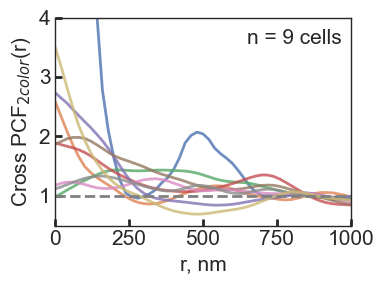

In [18]:
# Plot all individual PCF curves
plt.figure(figsize=(4, 3))

# Get individual cell data
pcf_per_cell = analysis_data["pcf_per_cell"]
bins = analysis_data["bins"] - dr_ring / 2
n_cells = len(pcf_per_cell)

# Plot each individual PCF curve
for i, pcf_curve in enumerate(pcf_per_cell):
    plt.plot(bins, pcf_curve, alpha=0.8, linewidth=2)

# Add reference line at PCF = 1
plt.axhline(1, ls="--", c="gray", lw=2)

# Plot settings
plt.xlim(bins[0], bins[-1])
plt.ylim(0.5, 4)  # Uncomment and adjust if needed
plt.xlabel("r, nm", fontsize=15)
plt.ylabel("Cross PCF$_{2color}$(r)", fontsize=15)

# Apply custom styling
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=15,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)

# Add cell count text box at top right corner
text_x = bins[-1] * 0.97  # 95% across x-axis (right side)
text_y = plt.ylim()[1] * 0.95  # 95% up y-axis (top)

plt.text(
    text_x,
    text_y,
    f"n = {n_cells} cells",
    fontsize=15,
    ha="right",
    va="top",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
)

plt.tight_layout()

# Save the plot
filename = f"individual_PCF_curves_{label.replace(' ', '_')}.png"
plt.savefig(filename, format="png", bbox_inches="tight", dpi=300)